In [66]:
import numpy as np
import numpy.matlib
from matplotlib import pyplot as plt
import math
import time
from keras.datasets import mnist

In [67]:
nSamples = 100

(train_digitImages, train_digitLabels) = mnist.load_data()[0]
(test_digitImages, test_digitLabels) = mnist.load_data()[1]

train_digitImages = train_digitImages[:nSamples]
train_digitLabels = train_digitLabels[:nSamples]

test_digitImages = test_digitImages[:nSamples]
test_digitLabels = test_digitLabels[:nSamples]

#normalize images data
train_digitImages = train_digitImages / 255.0
train_digitLabels = train_digitLabels / 255.0

#flatten data
flat_train_digitImages = train_digitImages.reshape(train_digitImages.shape[0], -1)
flat_test_digitImages = test_digitImages.reshape(test_digitImages.shape[0], -1)

In [68]:
def getEuclideanDistance(single_point,array):
    nrows, ncols, nfeatures=array.shape[0],array.shape[1], array.shape[2]
    points=array.reshape((nrows*ncols,nfeatures))
                         
    dist = (points - single_point)**2
    dist = np.sum(dist, axis=1)
    dist = np.sqrt(dist)

    dist=dist.reshape((nrows,ncols))
    return dist

In [69]:

mu, sigma = 0, 0.1
A = np.random.normal(mu, sigma, 10)
#A.shape, A

In [70]:
nrows,ncols,nfeatures=3,3,3

#Generate coordinate system
x,y=np.meshgrid(range(ncols),range(nrows))

In [71]:
sgm0=2
sgmdecay=0.05
t=1
sgm = sgm0 * math.exp(-t*sgmdecay);

width = math.ceil(sgm*3)

dist=np.array([[2,1,3],[3,2,3],[4,4,4]])
bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape) 

g = np.exp(-((np.power(x - bmucol,2)) + (np.power(y - bmurow,2))) / (2*sgm*sgm));


fromrow = max(0,bmurow - width);
torow   = min(bmurow + width,nrows);
fromcol = max(0,bmucol - width);
tocol   = min(bmucol + width,ncols);

In [72]:
#G = np.dstack([g[fromrow:torow,fromcol:tocol]]*nfeatures);

gg = g[fromrow:torow,fromcol:tocol]
G = np.repeat(gg, nfeatures).reshape((gg.shape[0], gg.shape[1], nfeatures))

In [73]:
def display_SOM(som, dispRes, nrows, ncols, title="SOM Features"):
    print(f"\n{title}:\n")
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
    
    for k in range(nrows):
        for l in range(ncols):
            A = som[k, l, :].reshape((dispRes[0], dispRes[1]))
            ax[k, l].imshow(A, cmap="plasma")
            ax[k, l].set_yticks([])
            ax[k, l].set_xticks([])   
    
    plt.show()


def SOM (dispRes, trainingData, ndim=10, nepochs=10, eta0=0.1, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=0):
    nfeatures=trainingData.shape[1]
    ntrainingvectors=trainingData.shape[0]
    
    nrows = ndim
    ncols = ndim
    
    mu, sigma = 0, 0.1
    numpy.random.seed(int(time.time()))
    som = np.random.normal(mu, sigma, (nrows,ncols,nfeatures))

    if showMode >= 1:
        display_SOM(som, dispRes, nrows, ncols, title="SOM Features before training") 
    
    #Generate coordinate system
    x,y=np.meshgrid(range(ncols),range(nrows))
    
    # Find the epoch at 50% of total epochs
    halfway_epoch = nepochs // 2  
    
    for t in range (1,nepochs+1):
        #Compute the learning rate for the current epoch
        eta = eta0 * math.exp(-t*etadecay);
        
        #Compute the variance of the Gaussian (Neighbourhood) function for the ucrrent epoch
        sgm = sgm0 * math.exp(-t*sgmdecay);
        
        #Consider the width of the Gaussian function as 3 sigma
        width = math.ceil(sgm*3);
        
        for ntraining in range(ntrainingvectors):
            trainingVector = trainingData[ntraining,:];
            
            # Compute the Euclidean distance between the training vector and
            # each neuron in the SOM map
            dist = getEuclideanDistance(trainingVector, som);
       
            # Find 2D coordinates of the Best Matching Unit (bmu)
            bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape) ;
            
            
            #Generate a Gaussian function centered on the location of the bmu
            g = np.exp(-((np.power(x - bmucol,2)) + (np.power(y - bmurow,2))) / (2*sgm*sgm));

            #Determine the boundary of the local neighbourhood
            fromrow = max(0,bmurow - width);
            torow   = min(bmurow + width,nrows);
            fromcol = max(0,bmucol - width);
            tocol   = min(bmucol + width,ncols);

            
            #Get the neighbouring neurons and determine the size of the neighbourhood
            neighbourNeurons = som[fromrow:torow,fromcol:tocol,:];
            sz = neighbourNeurons.shape;
            
            #Transform the training vector and the Gaussian function into 
            # multi-dimensional to facilitate the computation of the neuron weights update
            T = np.matlib.repmat(trainingVector,sz[0]*sz[1],1).reshape((sz[0],sz[1],nfeatures));                   
            G = np.dstack([g[fromrow:torow,fromcol:tocol]]*nfeatures);

            # Update the weights of the neurons that are in the neighbourhood of the bmu
            neighbourNeurons = neighbourNeurons + eta * G * (T - neighbourNeurons);

            #Put the new weights of the BMU neighbouring neurons back to the
            #entire SOM map
            som[fromrow:torow,fromcol:tocol,:] = neighbourNeurons;
    
        # Display SOM features after 50% of the iterations
        if showMode >= 1 and t == halfway_epoch:
            display_SOM(som, dispRes, nrows, ncols, title="SOM Features after 50% of training")

    if showMode >= 1:
        display_SOM (som, dispRes, nrows, ncols, title="SOM Features after training") 
        
    return som
    

In [74]:
import pandas as pd
def parse_input_zoo_data(filename, header='infer'):

    input_data = pd.read_csv(filename, header=header)

    classes = input_data[17].tolist()
    labels = input_data[0].tolist()
    input_database = {
        0: input_data[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]].to_numpy()
    }

    return input_database, labels, classes

In [75]:
input_filename = 'data/zoo.txt'
input_vector_database, labels, classes = parse_input_zoo_data(input_filename,None)


SOM Features before training:



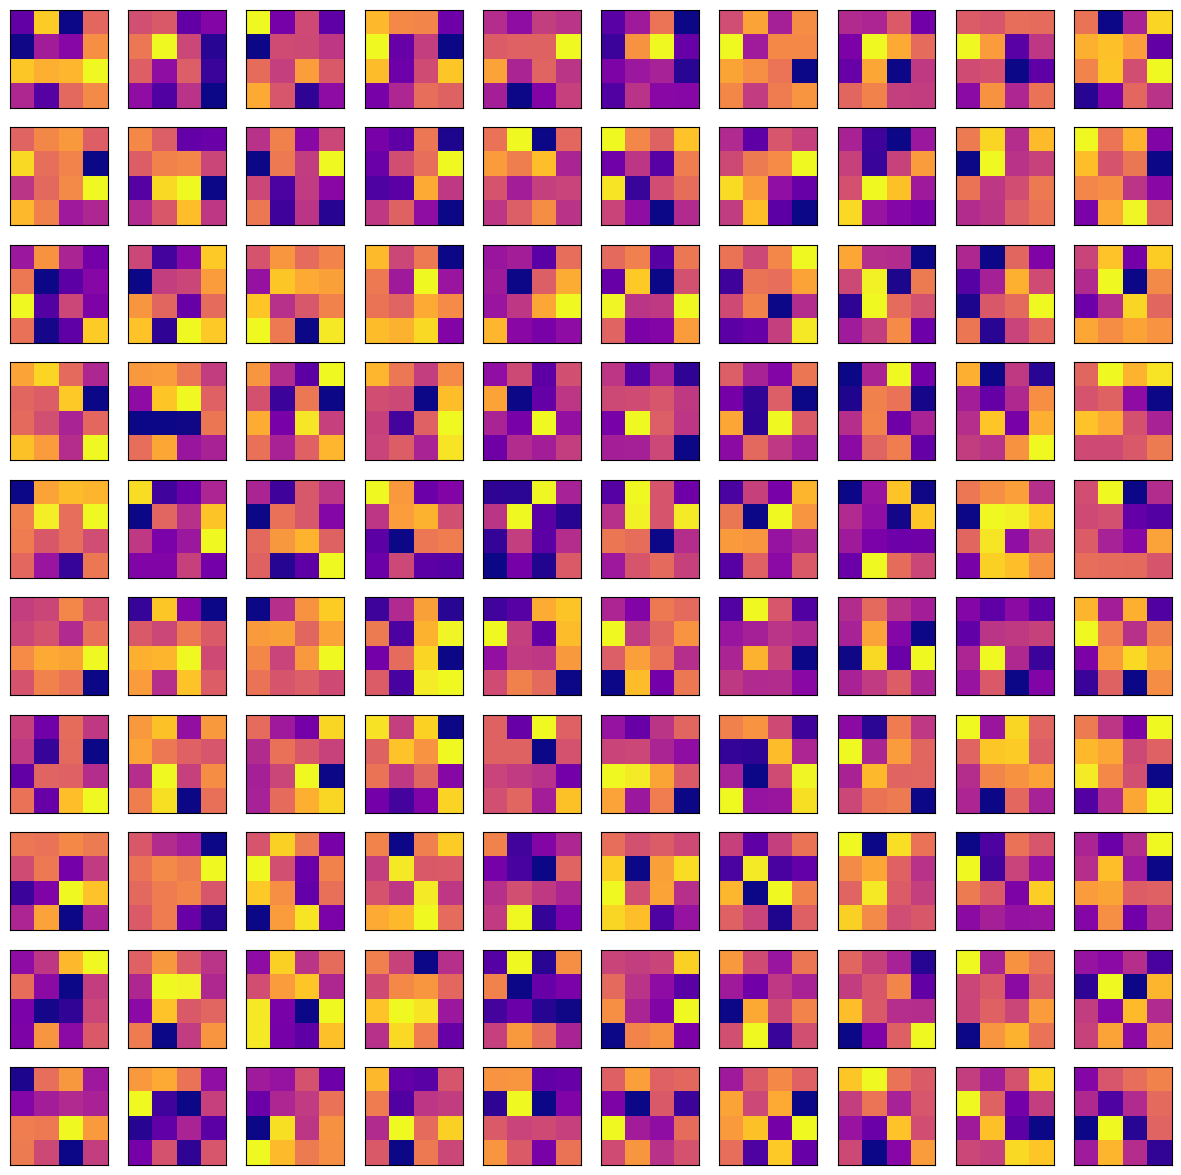


SOM Features after 50% of training:



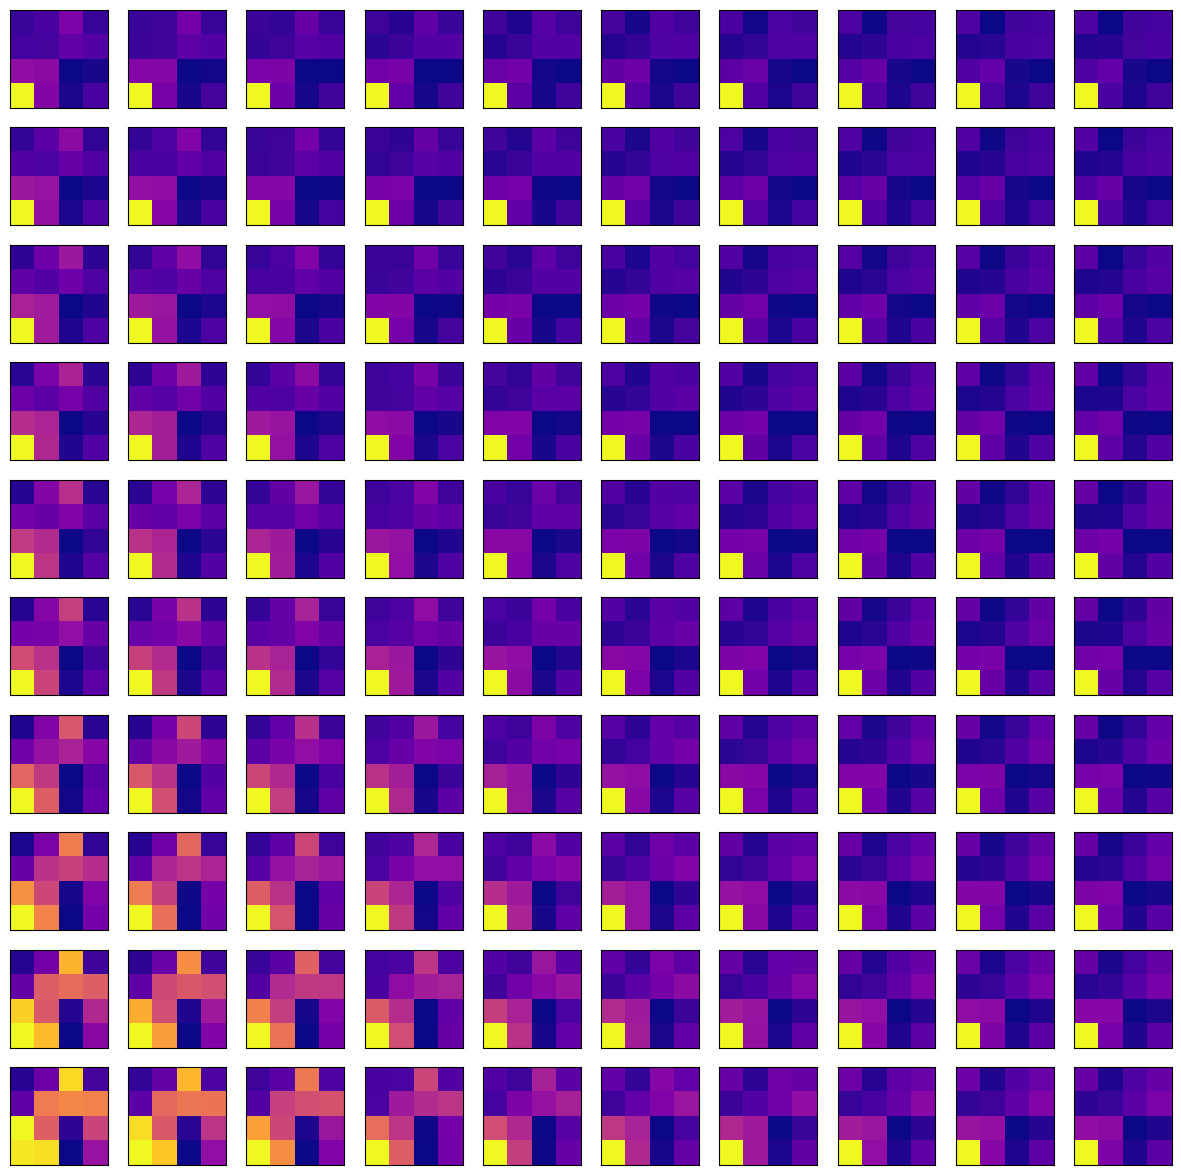


SOM Features after training:



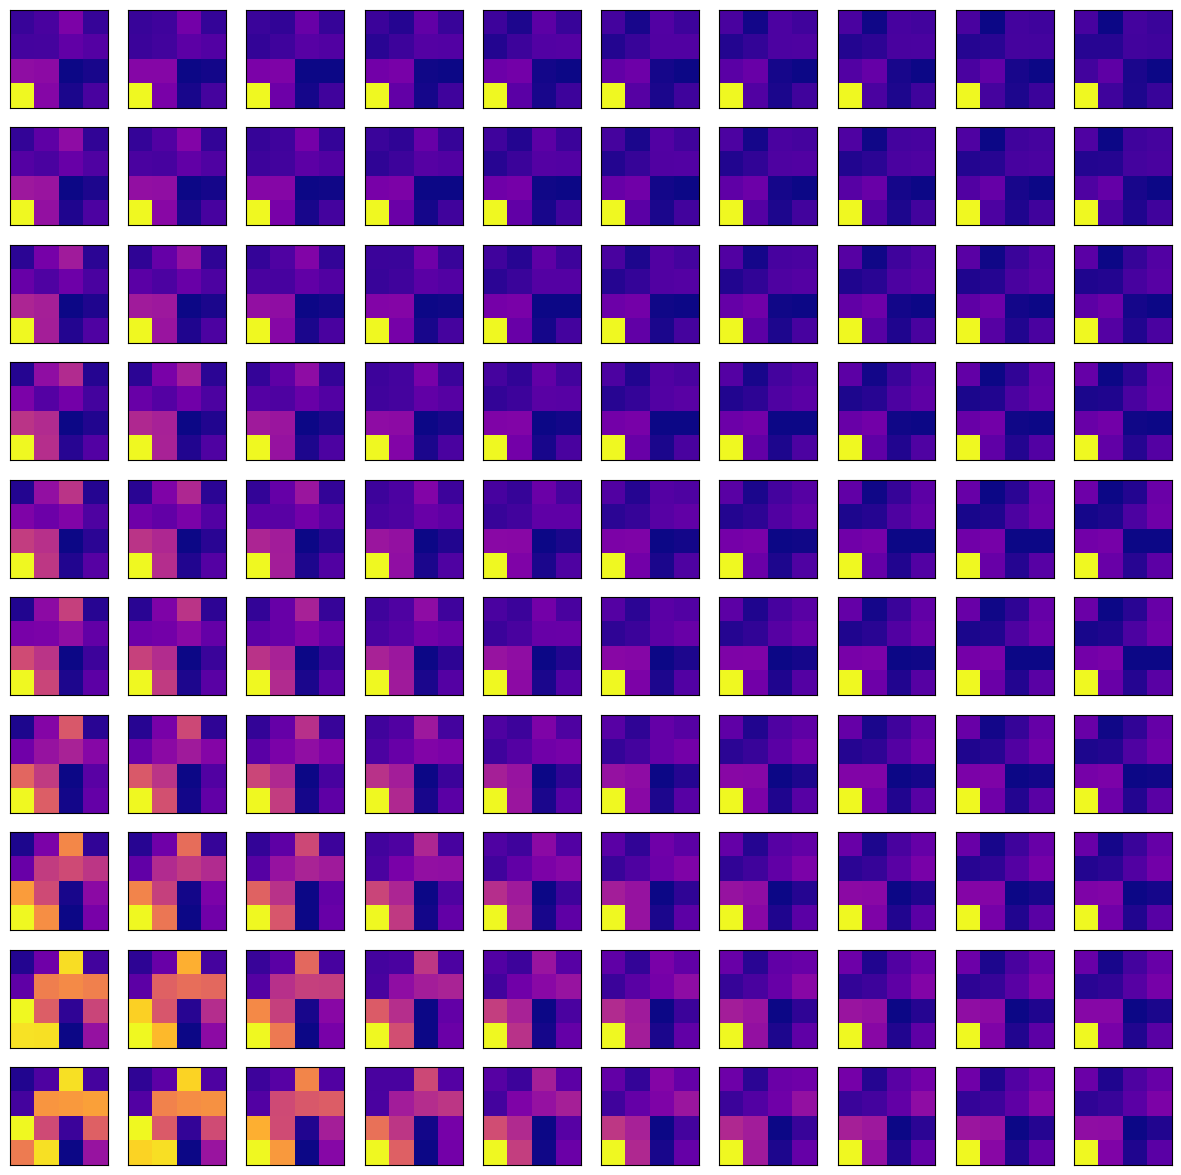

In [76]:
som_trained=SOM ([4,4],input_vector_database[0], ndim=10, nepochs=100, eta0=0.01, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=1)

In [77]:
plt.show()

# 20x20


SOM Features before training:



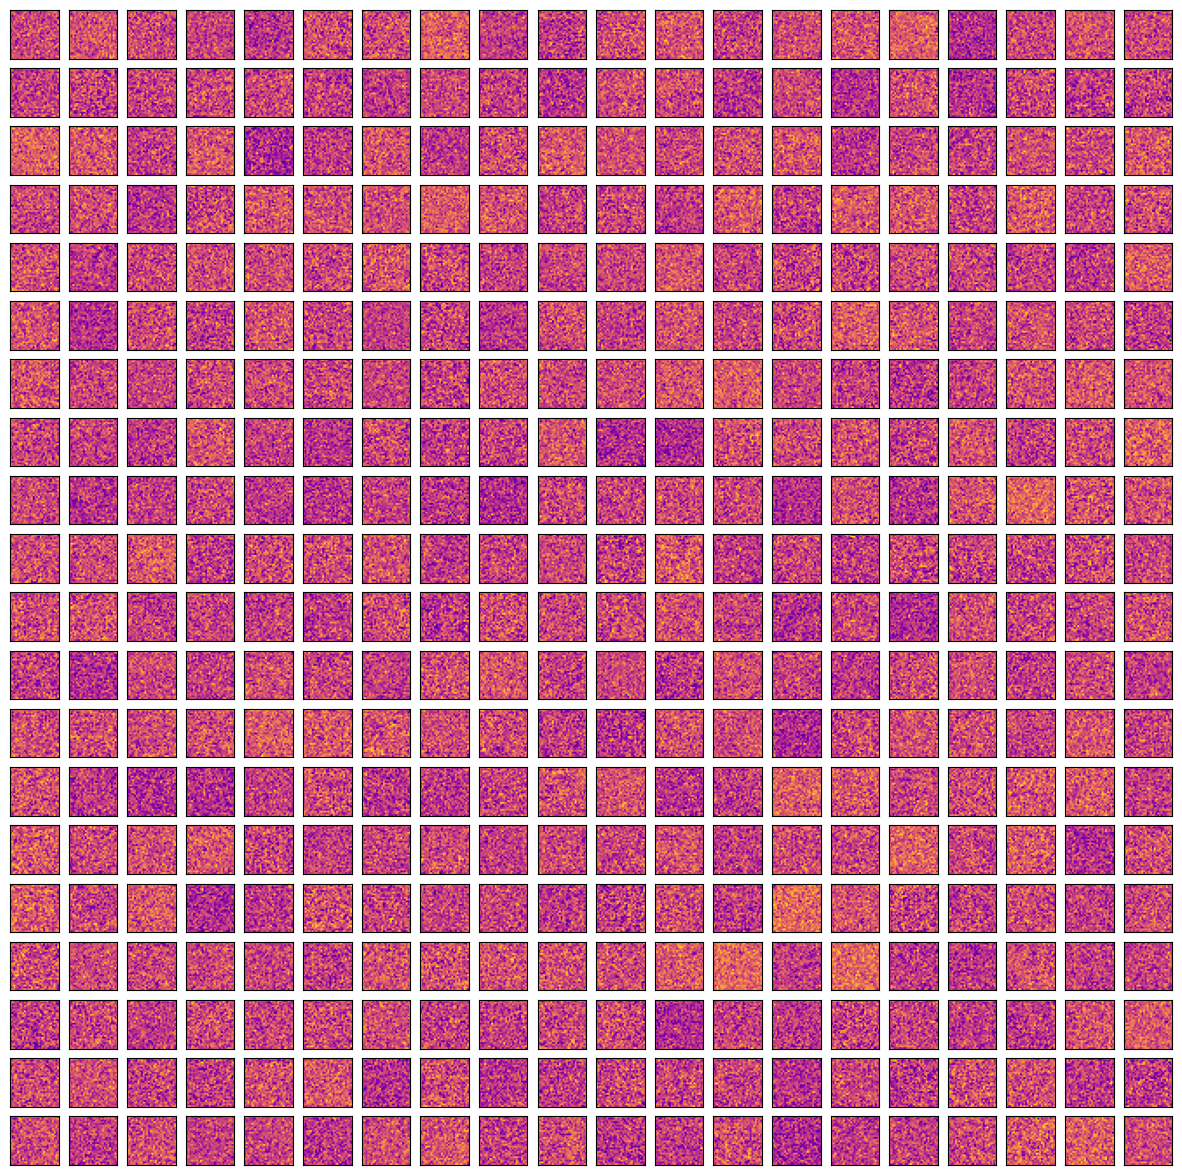


SOM Features after 50% of training:



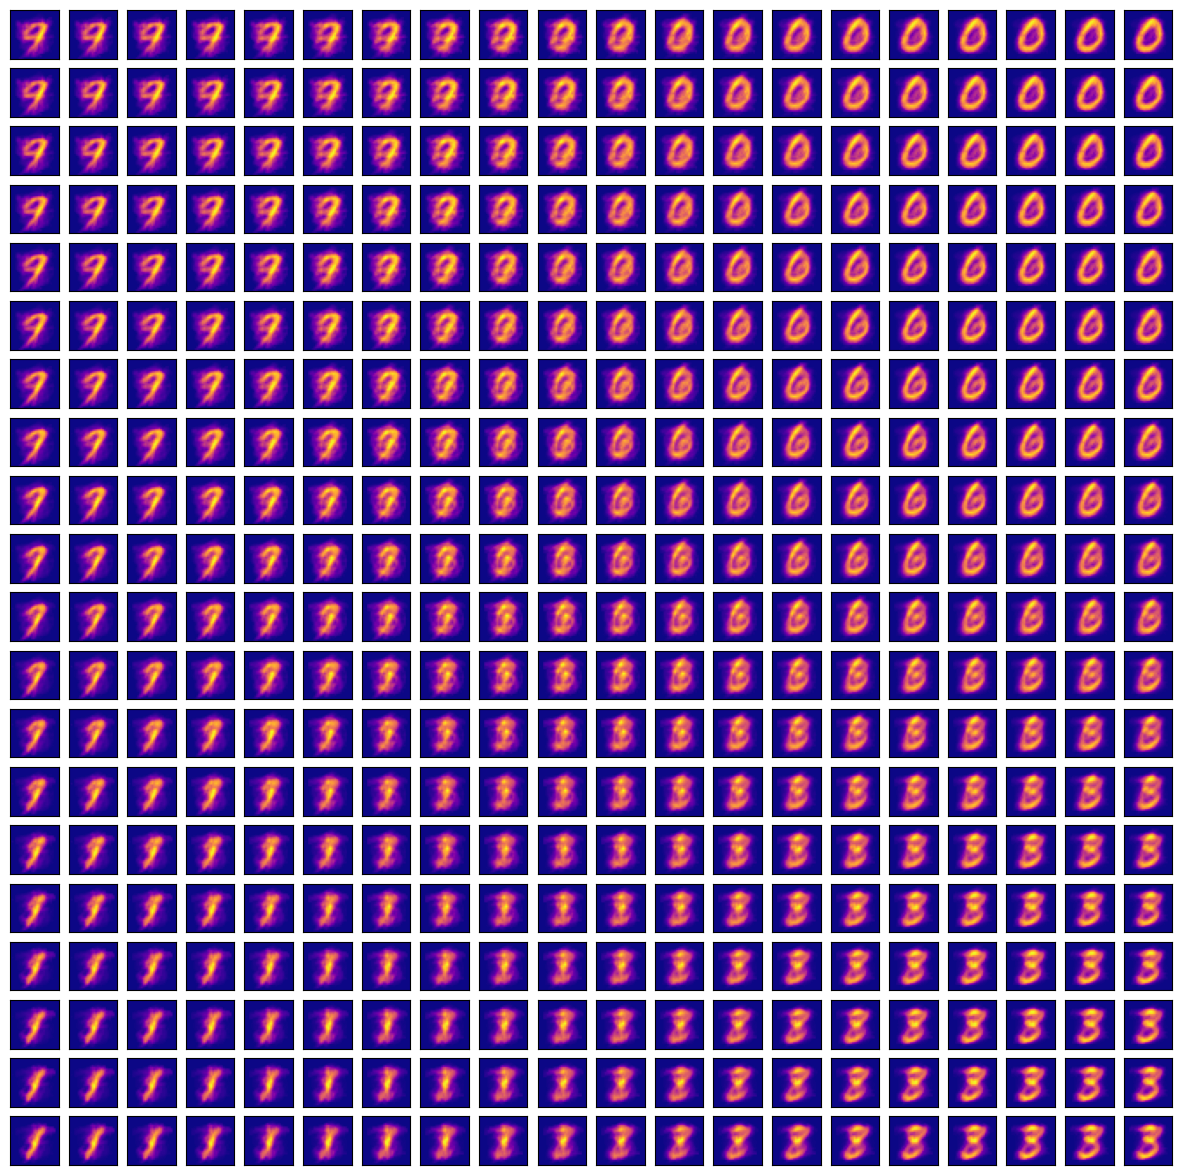


SOM Features after training:



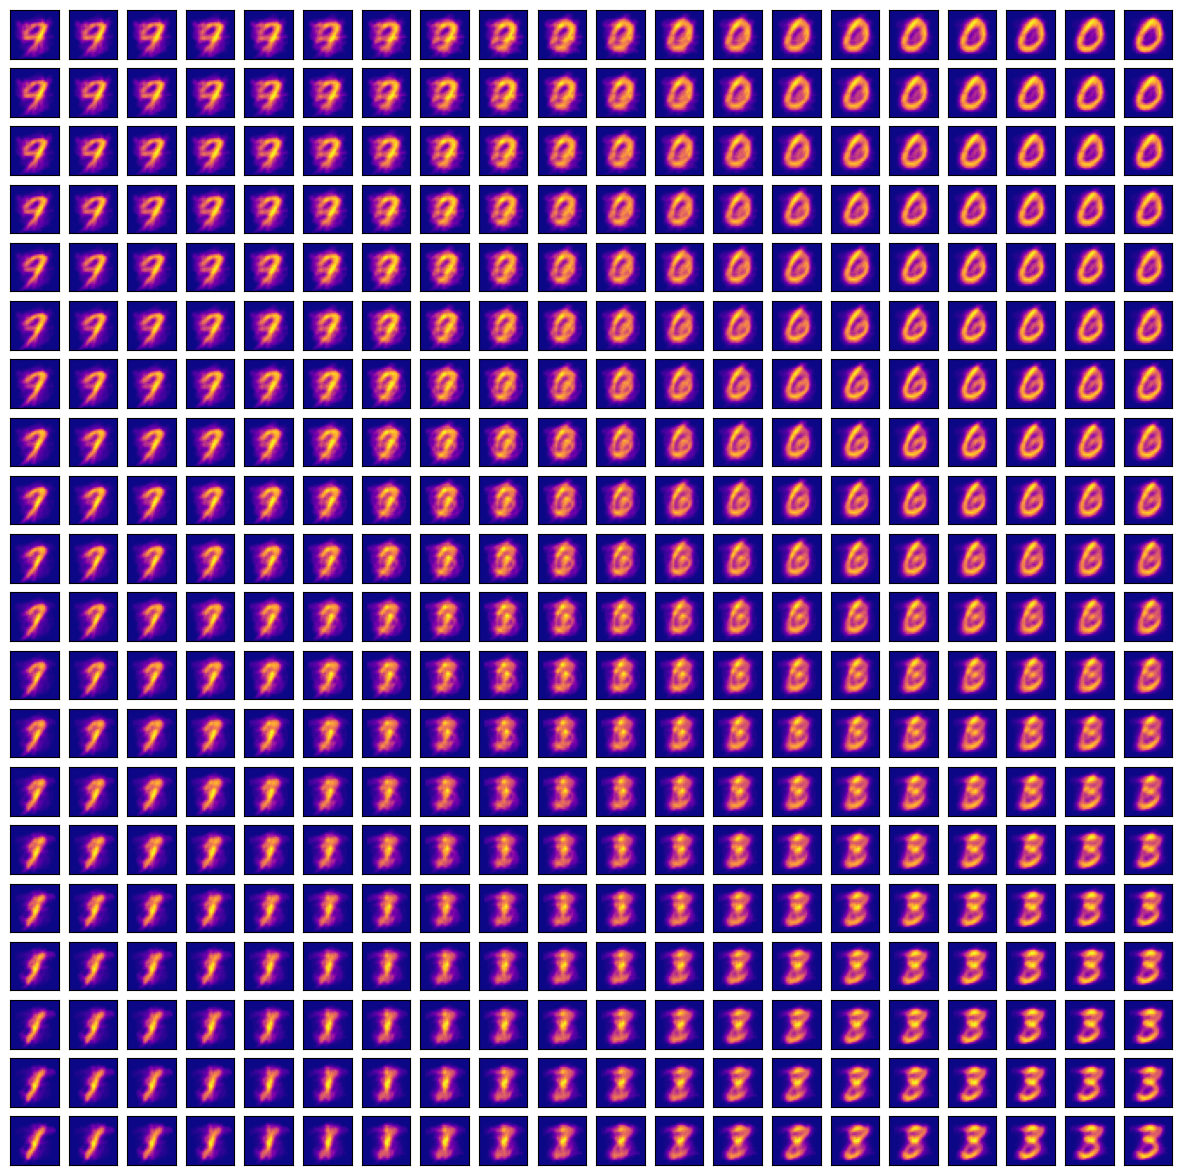

In [78]:
som_trained_20x20=SOM ([28,28], flat_train_digitImages, ndim=20, nepochs=100, eta0=0.01, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=1)
plt.show()

# 40x40

In [79]:
#som_trained_40x40=SOM ([28,28], flat_train_digitImages, ndim=40, nepochs=100, eta0=0.01, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=1)
#plt.show()

# 80x80

In [80]:
#som_trained_80x80=SOM ([28,28], flat_train_digitImages, ndim=80, nepochs=100, eta0=0.01, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=1)
#plt.show()

In [81]:
#verification of correctness on the training set:
def SOM_Test (trainingData, som_, classes, grid_, ConfusionMatrix, ndim):
    nfeatures=trainingData.shape[1]
    ntrainingvectors=trainingData.shape[0]
    
    nrows = ndim
    ncols = ndim
    
    nclasses=np.max(classes)

    som_cl=np.zeros((ndim,ndim,nclasses+1))
    
    for ntraining in range(ntrainingvectors):
        trainingVector = trainingData[ntraining,:];
        class_of_sample= classes[ntraining]
        # Compute the Euclidean distance between the training vector and
        # each neuron in the SOM map
        dist = getEuclideanDistance(trainingVector, som_);
       
        # Find 2D coordinates of the Best Matching Unit (bmu)
        bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape);
        
        som_cl[bmurow, bmucol,class_of_sample]=som_cl[bmurow, bmucol,class_of_sample]+1
    
    
    for i in range (nrows):
        for j in range (ncols):
            grid_[i,j]=np.argmax(som_cl[i,j,:])

 
    for ntraining in range(ntrainingvectors):
        trainingVector = trainingData[ntraining,:];
        class_of_sample= classes[ntraining]    
        # Compute the Euclidean distance between the training vector and
        # each neuron in the SOM map
        dist = getEuclideanDistance(trainingVector, som_);
       
        # Find 2D coordinates of the Best Matching Unit (bmu)
        bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape) ;
        
        predicted=np.argmax(som_cl[bmurow, bmucol,:])
        ConfusionMatrix[class_of_sample-1, predicted-1]=ConfusionMatrix[class_of_sample-1, predicted-1]+1
        
    return grid_, ConfusionMatrix
    

In [82]:
def generateConfusionMatrix(digitImages, SOM, ndim):
    nrows = ndim
    ncols = ndim
    gridColor = np.zeros((nrows, ncols))
    nclasses = np.max(classes)

    Confusion_Matrix = np.zeros((nclasses, nclasses))
    gridColor , Confusion_Matrix = SOM_Test  (digitImages, SOM, classes, gridColor, Confusion_Matrix, ndim)

    plt.close()
    plt.imshow(gridColor)
    plt.show()

    return Confusion_Matrix, flat_train_digitImages.shape, np.sum(Confusion_Matrix)

In [83]:
def SOM_accuracy(confusionMatrix):
    # np.trace calculates the summ of diagonal elements in the confusion matrix that represents the correctly classified samples
    truePositives = np.trace(confusionMatrix)
    samplesTotal = np.sum(confusionMatrix)
    classification_accuracy = truePositives / samplesTotal
    print("accuracy:", classification_accuracy)    

# confusion and accuracy 20x20


 Train set 20x20


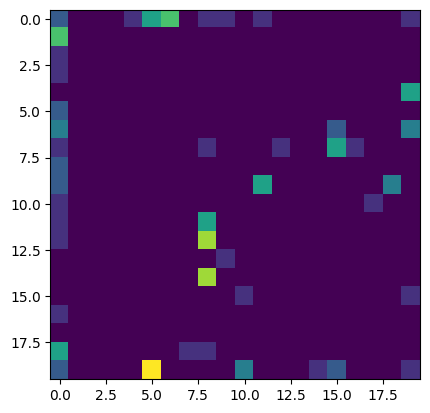

[[37.  4.  0.  0.  0.  0.  0.]
 [ 7. 12.  0.  0.  0.  0.  0.]
 [ 0.  1.  4.  0.  0.  0.  0.]
 [ 2.  2.  0.  8.  0.  0.  1.]
 [ 1.  0.  1.  0.  2.  0.  0.]
 [ 3.  1.  0.  1.  0.  2.  1.]
 [ 2.  5.  1.  0.  0.  0.  2.]]
accuracy: 0.67

 Test set 20x20


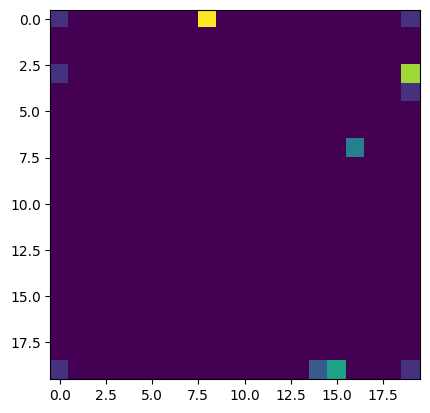

[[40.  1.  0.  0.  0.  0.  0.]
 [17.  2.  0.  0.  0.  0.  0.]
 [ 4.  0.  1.  0.  0.  0.  0.]
 [10.  2.  0.  1.  0.  0.  0.]
 [ 4.  0.  0.  0.  0.  0.  0.]
 [ 6.  1.  0.  0.  0.  1.  0.]
 [ 9.  0.  0.  0.  0.  0.  1.]]


In [84]:
print ('\n Train set 20x20')
confusion_train_ndim20 , shape , sum_matrix = generateConfusionMatrix(flat_train_digitImages, som_trained_20x20, ndim=20)
print(confusion_train_ndim20)
SOM_accuracy(confusion_train_ndim20)

print('\n Test set 20x20')
confusion_test_ndim20 , shape , sum_matrix = generateConfusionMatrix(flat_test_digitImages, som_trained_20x20, ndim=20)
print(confusion_test_ndim20)


In [85]:
#Confusion_Matrix, input_vector_database[0].shape, np.sum(Confusion_Matrix)

# 6


--- Training with learning rate: 0.01 ---


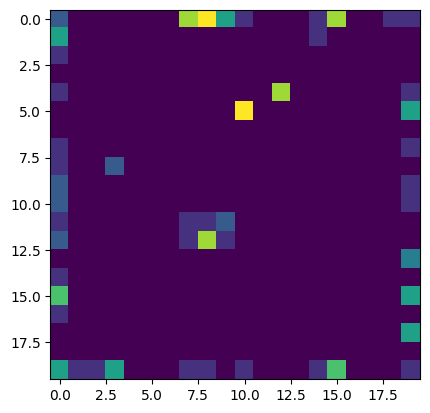

[[38.  3.  0.  0.  0.  0.  0.]
 [ 7. 10.  0.  2.  0.  0.  0.]
 [ 3.  1.  1.  0.  0.  0.  0.]
 [ 4.  0.  0.  9.  0.  0.  0.]
 [ 0.  1.  0.  1.  2.  0.  0.]
 [ 3.  0.  0.  0.  0.  4.  1.]
 [ 3.  3.  0.  1.  0.  0.  3.]]
accuracy: 0.67

--- Training with learning rate: 0.1 ---


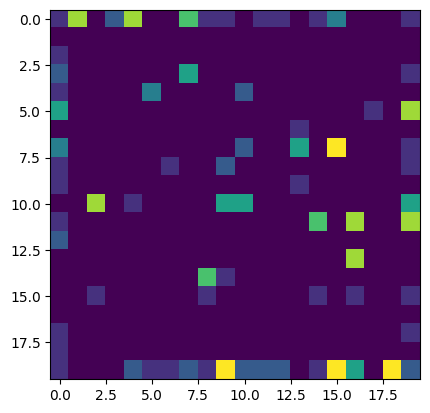

[[40.  1.  0.  0.  0.  0.  0.]
 [ 4. 15.  0.  0.  0.  0.  0.]
 [ 1.  1.  3.  0.  0.  0.  0.]
 [ 5.  1.  0.  7.  0.  0.  0.]
 [ 1.  0.  0.  0.  3.  0.  0.]
 [ 1.  0.  0.  0.  0.  7.  0.]
 [ 1.  3.  0.  1.  0.  1.  4.]]
accuracy: 0.79

--- Training with learning rate: 0.25 ---


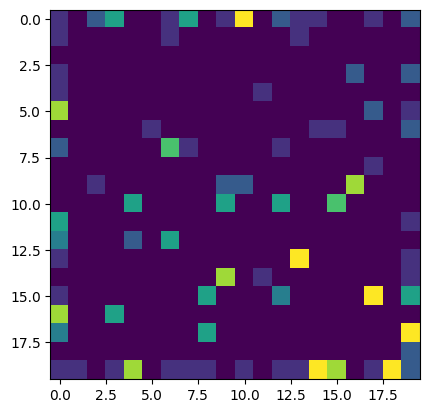

[[40.  1.  0.  0.  0.  0.  0.]
 [ 4. 15.  0.  0.  0.  0.  0.]
 [ 1.  1.  3.  0.  0.  0.  0.]
 [ 2.  0.  0. 11.  0.  0.  0.]
 [ 2.  0.  0.  0.  2.  0.  0.]
 [ 0.  2.  0.  0.  0.  6.  0.]
 [ 2.  1.  0.  0.  0.  1.  6.]]
accuracy: 0.83

--- Training with learning rate: 0.5 ---


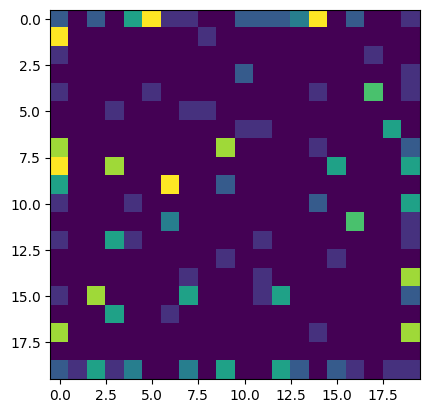

[[40.  1.  0.  0.  0.  0.  0.]
 [ 2. 17.  0.  0.  0.  0.  0.]
 [ 0.  1.  4.  0.  0.  0.  0.]
 [ 0.  0.  0. 13.  0.  0.  0.]
 [ 1.  0.  0.  1.  2.  0.  0.]
 [ 1.  0.  0.  0.  0.  7.  0.]
 [ 0.  4.  0.  0.  0.  1.  5.]]
accuracy: 0.88

--- Training with learning rate: 0.75 ---


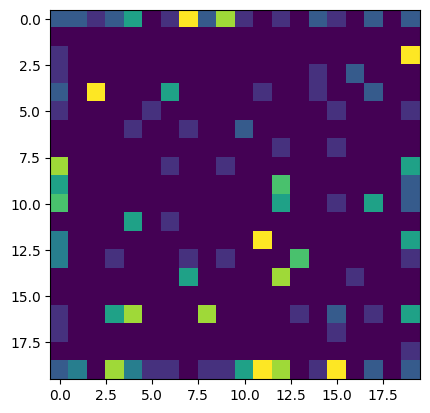

[[41.  0.  0.  0.  0.  0.  0.]
 [ 1. 18.  0.  0.  0.  0.  0.]
 [ 0.  1.  4.  0.  0.  0.  0.]
 [ 1.  0.  0. 12.  0.  0.  0.]
 [ 1.  0.  0.  0.  3.  0.  0.]
 [ 0.  1.  0.  0.  0.  7.  0.]
 [ 0.  3.  0.  1.  0.  0.  6.]]
accuracy: 0.91

--- Training with learning rate: 0.85 ---


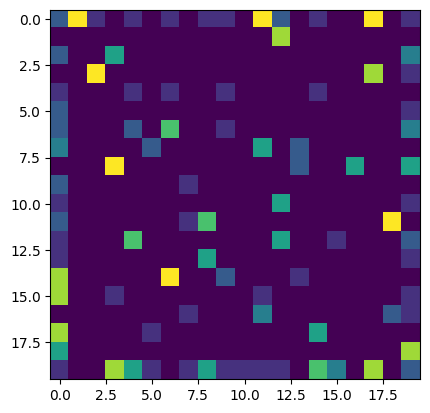

[[40.  1.  0.  0.  0.  0.  0.]
 [ 2. 17.  0.  0.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.  0.  0.]
 [ 2.  0.  0. 11.  0.  0.  0.]
 [ 0.  0.  0.  0.  4.  0.  0.]
 [ 0.  0.  0.  0.  0.  8.  0.]
 [ 0.  1.  0.  1.  0.  1.  7.]]
accuracy: 0.92

--- Training with learning rate: 0.95 ---


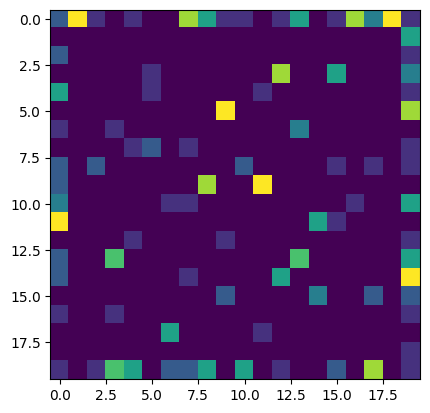

[[40.  1.  0.  0.  0.  0.  0.]
 [ 3. 16.  0.  0.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.  0.  0.]
 [ 0.  0.  0. 13.  0.  0.  0.]
 [ 1.  0.  0.  0.  3.  0.  0.]
 [ 1.  1.  0.  0.  0.  6.  0.]
 [ 0.  1.  0.  2.  0.  1.  6.]]
accuracy: 0.89


In [86]:
# learning rates
learning_rates = [0.01, 0.1, 0.25, 0.5, 0.75, 0.85, 0.95]

for eta0 in learning_rates:
    print(f"\n--- Training with learning rate: {eta0} ---")
    som = SOM([28, 28], flat_train_digitImages, ndim=20, nepochs=100, eta0=eta0, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=0)
    
    confusion_matrix, shape, sum_matrix = generateConfusionMatrix(flat_train_digitImages, som, ndim=20)
    print(confusion_matrix)
    SOM_accuracy(confusion_matrix)

# 7

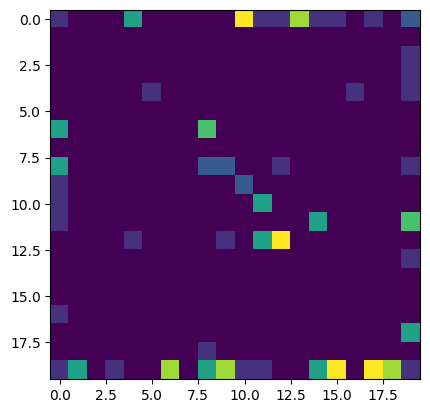

[[38.  3.  0.  0.  0.  0.  0.]
 [10.  9.  0.  0.  0.  0.  0.]
 [ 4.  1.  0.  0.  0.  0.  0.]
 [ 2.  0.  0. 11.  0.  0.  0.]
 [ 1.  1.  0.  0.  2.  0.  0.]
 [ 3.  0.  0.  0.  1.  4.  0.]
 [ 5.  1.  0.  0.  0.  0.  4.]]
accuracy: 0.68


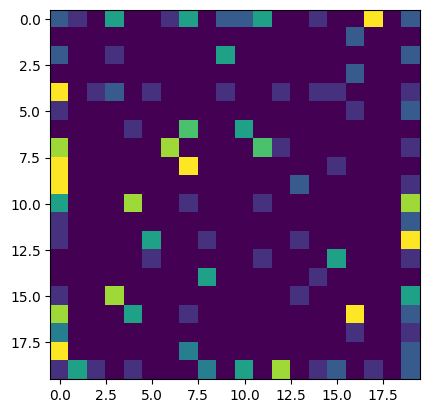

[[41.  0.  0.  0.  0.  0.  0.]
 [ 2. 17.  0.  0.  0.  0.  0.]
 [ 1.  1.  3.  0.  0.  0.  0.]
 [ 0.  0.  0. 13.  0.  0.  0.]
 [ 1.  0.  0.  1.  2.  0.  0.]
 [ 0.  1.  0.  0.  0.  7.  0.]
 [ 0.  2.  0.  0.  0.  0.  8.]]
accuracy: 0.91


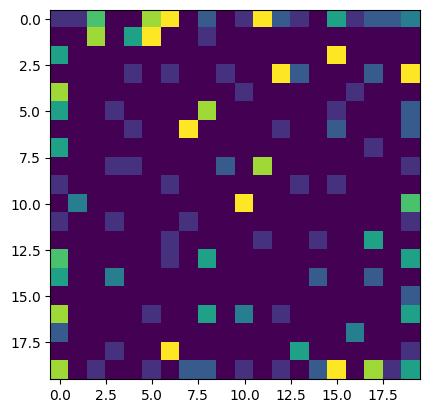

[[41.  0.  0.  0.  0.  0.  0.]
 [ 2. 17.  0.  0.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.  0.  0.]
 [ 0.  0.  0. 13.  0.  0.  0.]
 [ 1.  0.  0.  0.  3.  0.  0.]
 [ 0.  0.  0.  0.  0.  8.  0.]
 [ 0.  0.  0.  0.  0.  0. 10.]]
accuracy: 0.97


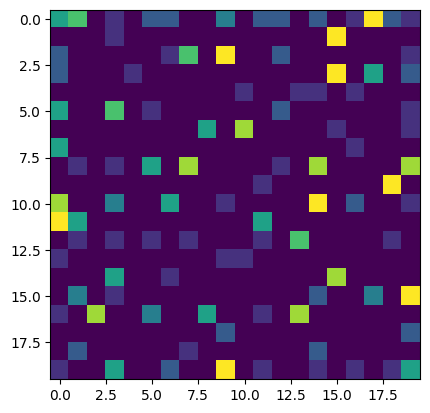

[[41.  0.  0.  0.  0.  0.  0.]
 [ 1. 18.  0.  0.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.  0.  0.]
 [ 0.  0.  0. 13.  0.  0.  0.]
 [ 0.  0.  0.  0.  4.  0.  0.]
 [ 0.  0.  0.  0.  0.  8.  0.]
 [ 0.  0.  0.  0.  0.  0. 10.]]
accuracy: 0.99


In [87]:
# best learing rat with eta0 = 0.75 

sgmdecay_values = [0.01, 0.05, 0.1, 0.5]
for sgmdecay in sgmdecay_values:
    som = SOM([28, 28], flat_train_digitImages, ndim=20, nepochs=100, eta0=0.75, etadecay=0.05, sgm0=20, sgmdecay=sgmdecay, showMode=0)

    confusion_matrix, shape, sum_matrix = generateConfusionMatrix(flat_train_digitImages, som, ndim=20)
    print(confusion_matrix)
    SOM_accuracy(confusion_matrix)

# Theory Questions 
6 :  For a fixed number of iterations increase and decrease the learning rate of SOM, What is the resulting effect? 

     The accuracy increases to a thereshold around .75 then the benifits of its increase diminishes into confusion in the classification.

7 : For a fixed number of iterations and the best learning rate increase and decrease the exponential decay of the neighbourhood paramete , what is the effect ?

     This make the neighborhood size converge slower resulting in more robust and careful clustering of data thus we se an increase in accuracy through the whole increase of this parameter at a cost of computing resources.

9 : What is a biological neuron? How does it relate to the concept of neurons in SOM?

     A biological neuron is an electron within the nervosystem of a human, neurons are aslo known as nervecells if I am not mistaken, thier function is to carry information signals throug our biological structures over our nervous system when we use our motrofunction consciousnessly (moving around) as well as unconciouss function like the pumping of our heart. It seems like SOM draws inspiration from biological neurons for learning in particular, say the repetetive task of learning how to walk as an infant our neurons fire repetetively and correcting our actions through our learning process untill we walk wihtout falling. Much like how our SOM model uppdates its weights to increase its classification corrrectness by every iteration of neuron firering.